<a href="https://colab.research.google.com/github/michalisgalanis/garbage-detection-internship/blob/main/Garbage_Detection_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A. Pre-processing**

## Acquiring the TACO dataset
TACO is a growing image dataset of waste in the wild. It contains images of litter taken under diverse environments: woods, roads and beaches. These images are manually labeled and segmented according to a hierarchical taxonomy to train and evaluate object detection algorithms. Currently, images are hosted on
Flickr and we have a server that is collecting more images and annotations.

Get more information [here](https://github.com/pedropro/TACO).

In [2]:
# 0. Clear Data
import os, shutil
if os.path.exists('sample_data/'): shutil.rmtree('sample_data/')

In [ ]:
# 2.1 Clone & Download dataset
#!git clone https://github.com/pedropro/TACO
#%cd /content/TACO
#!python3 download.py

In [3]:
# 2.2 OR Upload TACO.zip with 2-3 images (for simplicity's sake)
import os, shutil

%cd /content
if os.path.exists('/content/TACO'): shutil.rmtree('/content/TACO')
!unzip /content/TACO.zip
if os.path.exists('/content/TACO.zip'): os.remove('TACO.zip')

/content
Archive:  /content/TACO.zip
   creating: TACO/
   creating: TACO/data/
  inflating: TACO/data/annotations.json  
   creating: TACO/data/batch_1/
  inflating: TACO/data/batch_1/000000.jpg  
  inflating: TACO/data/batch_1/000001.jpg  
  inflating: TACO/data/batch_1/000003.jpg  
  inflating: TACO/data/batch_1/000004.jpg  


## Organize files & folders

In [4]:
# 3. Move all images from multiple batch folders to a new single folder.
import os
import shutil

root_path = 'TACO'
data_path = os.path.join(root_path, 'data')
image_path = os.path.join(data_path, 'images')

# Create new folder 'images'
if os.path.exists(image_path):
    shutil.rmtree(image_path)
os.mkdir(image_path)

for batch in os.listdir(data_path):
    if os.path.isdir(data_path) and 'batch' in batch:
        for image in os.listdir(os.path.join(data_path, batch)):
            shutil.move(os.path.join(data_path, batch, image), os.path.join(image_path, batch + '_' + image))
        shutil.rmtree(os.path.join(data_path, batch))

In [5]:
# 4. Split dataset into train, val and test
import random
import math

folder_ratios = {'train': (0, 0.7),
                 'val': (0.7, 1)}

json_filename = 'annotations.json'

images = os.listdir(image_path)
random.shuffle(images)
folder_images = {}

for f, r in folder_ratios.items():
    folder_images[f] = images[math.floor(r[0] * len(images)):math.floor(r[1] * len(images))]

# Create train & val folders
for folder in folder_ratios.keys():
    current_path = os.path.join(data_path, folder)

    # Create directory
    if os.path.exists(current_path):
        shutil.rmtree(current_path)
    os.mkdir(current_path)

    # Move split images
    for current_image in folder_images[folder]:
        shutil.move(os.path.join(image_path, current_image), os.path.join(current_path, current_image))

    # Remove old folders and copy annotations to both splits
    if folder != 'test':
        shutil.copy(os.path.join(data_path, json_filename), os.path.join(current_path, json_filename))


shutil.rmtree(image_path)
os.remove(os.path.join(data_path, json_filename))

# **B. Training**

### Setting up training process

In [6]:
# TRIAL 1
!pip uninstall -y tensorflow
!pip uninstall -y tensorflow-gpu

!pip install tensorflow==1.3
!pip install tensorflow-gpu==1.14
!pip install keras==2.0.8

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 43.6MB 70kB/s 
     |████████████████████████████████| 1.6MB 54.8MB/s 
     |████████████████████████████████| 890kB 43.7MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=0a8e18216a07aff671f95e903221beb0ca98b261e671c00ec13d5a0f804e6736
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.2.1
    Uninstalling bleach-3.2.1:
      Successfully uninstalled bleach-3.2.1
     |████████████████████████████████| 377.0MB 44kB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 3.2MB 50.7MB/s 
     |████████████████████████████████| 491kB 52.9MB/

In [7]:
# 1. Clone Mask_RCNN repo
import os, shutil

model_path = '/content/Mask_RCNN'
if os.path.exists(model_path): shutil.rmtree(model_path)

!git clone https://github.com/matterport/Mask_RCNN /content/Mask_RCNN

Cloning into '/content/Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.85 MiB | 37.59 MiB/s, done.
Resolving deltas: 100% (563/563), done.


**Warning: Restart Runtime and IMPORT FILES BEFORE CONTINUING**

In [13]:
# 2. Configure Dataset
import sys
import os
import json
import skimage.io
import numpy as np

root_path = 'TACO'
data_path = os.path.join(root_path, 'data')
image_path = os.path.join(data_path, 'images')

%cd /content

# Root directory of the project
ROOT_DIR = os.path.abspath("TACO") 
sys.path.append(ROOT_DIR)

train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'val')
json_filename = 'annotations.json'

from Mask_RCNN.mrcnn.config import Config

%cd /content/Mask_RCNN/

from mrcnn import model as modellib, utils

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

class GarbageConfig(Config):
    # Give the configuration a recognizable name
    NAME = "garbage"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 60  # Background + garbage categories

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    IMAGE_MIN_DIM = 1024

class GarbageDataset(utils.Dataset):

    def load_garbage(self, dataset_dir, subset):
        # Read JSON file
        json_dict = json.load(open(os.path.join(train_path, json_filename)))
        for category in json_dict['categories']:
            # Add every class (60 categories)
            #self.add_class(category['supercategory'], category['id'], category['name'])
            self.add_class('garbage', category['id'], category['name'])

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        images_dict = json_dict['images']
        annotations = json_dict['annotations']

        for image in images_dict:
            if not (image['file_name'].rpartition('/')[0] + '_' + image['file_name'].rpartition('/')[2]) in os.listdir(dataset_dir):
                continue

            polygons = []
            for ann in annotations:
                if ann['image_id'] == image['id']:
                    polygons.append(ann)

            image_path = os.path.join(dataset_dir, (image['file_name'].rpartition('/')[0] + '_' + image['file_name'].rpartition('/')[2]))
            if not 'jpg' in image_path:
                continue

            # Resize Images
            img = skimage.io.imread(image_path)
            # height_original, width_original = img.shape[:2]
            # original_shape = img.shape

            # img, window, scale, padding, _ = utils.resize_image(
            #     img, 
            #     min_dim=config.IMAGE_MIN_DIM, 
            #     max_dim=config.IMAGE_MAX_DIM,
            #     mode=config.IMAGE_RESIZE_MODE)
            height, width = img.shape[:2]

            # skimage.io.imsave(image_path, img)

            self.add_image(
                image_id = image['id'],
                source = 'garbage',
                path = image_path,

                width = width, height = height,
                # width_original = width_original,
                # height_original = height_original,

                polygons = polygons,
                # scale = scale,
                # padding = padding
                ) # polygons includes annotation


    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["polygons"]

        assert annotations

        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = annotation['category_id']
            if class_id:
                m = utils.annToMask(annotation, image_info["height"],image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.

                if m.max() < 1:
                    continue

                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array and then resize mask
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids

/content
/content/Mask_RCNN


### Train


In [14]:
%cd /content/TACO

config = GarbageConfig()
#config.display()

model = modellib.MaskRCNN(mode="training", config = config, model_dir = DEFAULT_LOGS_DIR)

# Path to trained weights file
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"
COCO_WEIGHTS_OUT_PATH = "mask_rcnn_garbage.h5"

# Download weights file
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)


print("Loading weights ", COCO_WEIGHTS_PATH)
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"], weights_out_path=COCO_WEIGHTS_OUT_PATH)

%cd /content/

# Training dataset.
dataset_train = GarbageDataset()
dataset_train.load_garbage(data_path, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = GarbageDataset()
dataset_val.load_garbage(data_path, "val")
dataset_val.prepare()

/content/TACO
Loading weights  mask_rcnn_coco.h5
/content


In [15]:
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='heads') 

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/TACO/logs/garbage20201014T0742/mask_rcnn_garbage_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may du

before (751, 1241, 1)
(751, 1241, 3)
1
before (2049, 1537, 1)
Epoch 1/1
(2049, 1537, 3)
0
scale 0.8251410153102336 padding [(202, 202), (0, 0), (0, 0)] crop None
after (1024, 1024, 1)
scale 0.4997559785261103 padding [(0, 0), (128, 128), (0, 0)] crop None
after (1024, 1024, 1)
before (2049, 1537, 1)
(2049, 1537, 3)
0
before (751, 1241, 1)
(751, 1241, 3)
1
scale 0.4997559785261103 padding [(0, 0), (128, 128), (0, 0)] crop None
scale 0.8251410153102336 padding [(202, 202), (0, 0), (0, 0)] crop None
after (1024, 1024, 1)
after (1024, 1024, 1)
before (751, 1241, 1)
(751, 1241, 3)
1
before (751, 1241, 1)
(751, 1241, 3)
1
scale 0.8251410153102336 padding [(202, 202), (0, 0), (0, 0)] crop None
scale 0.8251410153102336 padding [(202, 202), (0, 0), (0, 0)] crop None
after (1024, 1024, 1)
after (1024, 1024, 1)
before (2049, 1537, 1)
(2049, 1537, 3)
0
before (2049, 1537, 1)
(2049, 1537, 3)
0
scale 0.4997559785261103 padding [(0, 0), (128, 128), (0, 0)] crop None
after (1024, 1024, 1)
before (751,

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


before (2049, 1537, 1)
(2049, 1537, 3)
1
before (2049, 1537, 1)
(2049, 1537, 3)
1
scale 0.4997559785261103 padding [(0, 0), (128, 128), (0, 0)] crop None
scale 0.4997559785261103 padding [(0, 0), (128, 128), (0, 0)] crop None
after (1024, 1024, 1)
after (1024, 1024, 1)
before (1537, 2049, 2)
(1537, 2049, 3)
0
before (1537, 2049, 2)
(1537, 2049, 3)
0
scale 0.4997559785261103 padding [(128, 128), (0, 0), (0, 0)] crop None
scale 0.4997559785261103 padding [(128, 128), (0, 0), (0, 0)] crop None
after (1024, 1024, 2)
after (1024, 1024, 2)
before (2049, 1537, 1)
(2049, 1537, 3)
before (1537, 2049, 2)
1
(1537, 2049, 3)
0
scale 0.4997559785261103 padding [(0, 0), (128, 128), (0, 0)] crop None
after (1024, 1024, 1)
scale 0.4997559785261103 padding [(128, 128), (0, 0), (0, 0)] crop None
after (1024, 1024, 2)
before (1537, 2049, 2)
(1537, 2049, 3)
0
scale 0.4997559785261103 padding [(128, 128), (0, 0), (0, 0)] crop None
before (2049, 1537, 1)
(2049, 1537, 3)
after (1024, 1024, 2)
1
scale 0.499755

# **C. Testing**

In [16]:
# Test Setup
class InferenceConfig(GarbageConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_SCORE_RATIO = True


Instructions for updating:
Use `tf.cast` instead.
/content
0
before (1537, 2049, 2)
(1537, 2049, 3)
0
scale 0.4997559785261103 padding [(128, 128), (0, 0), (0, 0)] crop None
after (1024, 1024, 2)
(1024, 1024, 3)
(1024, 1024)
(1024, 1024, 3)
(1024, 1024)


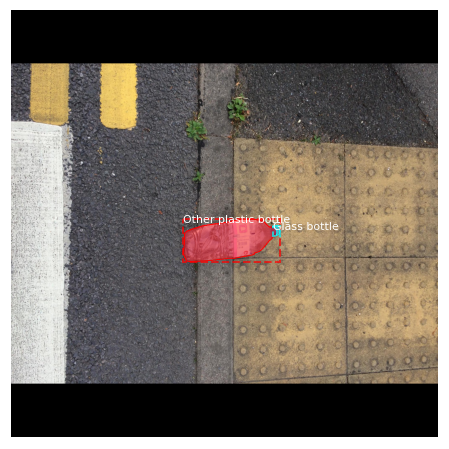

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 73)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [17]:
import random
from mrcnn import visualize

inference_config = InferenceConfig()

COCO_WEIGHTS_OUT_PATH = "mask_rcnn_garbage.h5"

# Create Testing Model and load Weights
model = modellib.MaskRCNN(mode="inference", config = inference_config, model_dir = DEFAULT_LOGS_DIR)
dir_name, cp = model.find_last()

model.load_weights(cp, by_name=True, weights_out_path=COCO_WEIGHTS_OUT_PATH)

%cd /content/

# Pick an image to test the detection
image_path = random.choice([x for x in os.listdir(os.path.join(data_path, 'val')) if 'jpg' in x])

dataset_image_id = -1
counter = 0
for info in dataset_val.image_info:
    if image_path in info['path']:
        dataset_image_id = counter
        break
    counter += 1

print(dataset_image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           dataset_image_id, use_mini_mask=False)
    
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                        dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
print([x for x in dataset_val.image_info])

In [ ]:
print([x for x in dataset_val.image_info if x['id'] == 36])

In [ ]:
print(image_path)